In [1]:
import numpy as np

from model import ViT4CLS, Bert4CLS, Bridge, Bridge2
import torch
from torch import nn


In [2]:
from TrainAndData.VQAv2 import VQAv2, collate4VQA4BertViT
from torch.utils.data import DataLoader
v2 = VQAv2("F:\\datasets\\MultiModal\\VQAv2")

loading VQA annotations and questions into memory...
0:00:21.328911
creating index...
index created!


In [3]:
class PytorchAttMapGetter():
    def __init__(self, in_proj, d, h, ln=None):
        self.Wq = in_proj[:d]
        self.Wk = in_proj[d: 2 * d]
        self.scaling = float(d // h) ** -0.5
        self.map = None
        self.ln = None
        if ln is not None:
            self.ln = ln

    def __call__(self, module, input, output):
        if self.ln is not None:
            input = self.ln(input[0])
        else:
            input = input[0]

        q = input @ self.Wq
        q *= self.scaling
        k = input @ self.Wk
        A = nn.functional.softmax(torch.bmm(q, k.transpose(1, 2)), dim=-1)
        self.map = A.squeeze(0)

In [4]:
bridge = torch.load("./outcomes/10.pth", map_location=torch.device('cpu'))

vitGetters = [PytorchAttMapGetter(bridge.visual.Backbone.encoder.layers[i].self_attention.in_proj_weight, 768, 8, bridge.visual.Backbone.encoder.layers[i].ln_1) for i in range(12)]
bridgeGetters = [PytorchAttMapGetter(bridge.resblocks[i].self_attn.in_proj_weight, 768, 8) for i in range(6)]

for i in range(12):
    bridge.visual.Backbone.encoder.layers[i].register_forward_hook(vitGetters[i])
for i in range(6):
    bridge.resblocks[i].self_attn.register_forward_hook(bridgeGetters[i])

In [5]:
VQAtrain = DataLoader(v2, batch_size=1, collate_fn=collate4VQA4BertViT)
gts = []
infers = []
Rs = []

for i, (img, seq, pad, label) in enumerate(VQAtrain):
    if i >= 12:
        break

    R = torch.eye(50)

    img = img
    seq = seq
    pad = pad
    label = label.squeeze(0)
    label = torch.argmax(label).item()
    gts.append(label)

    predict = bridge(img, seq, pad).squeeze(0)
    predict = torch.argmax(predict).item()
    infers.append(predict)

    for j in range(12):
        R += vitGetters[j].map @ R

    for j in range(6):
        R += bridgeGetters[j].map[:50, :50] @ R

    Rs.append(R)

In [6]:
gts = [v2.cls2ans[str(gt)] for gt in gts]
infers = [v2.cls2ans[str(infer)] for infer in infers]
Rs = [R.detach().numpy() for R in Rs]


In [7]:
heat = sum(Rs[6])[1:].reshape(7, 7)

Text(0.5, 1.0, 'Question: What color is the persons headwear?\nModel Predict: red\nGround Truth: red')

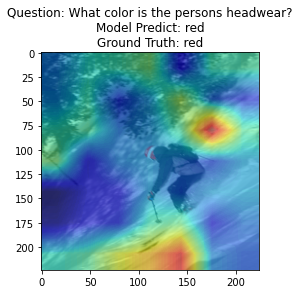

In [10]:
import PIL.Image as Image
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

heat = cv2.resize(heat[:, :], (224, 224))
img = Image.open(v2[6][0]).resize((224, 224))
heat_mask = heat / heat.max()
heat_mask = (heat_mask * 255).astype('uint8')
plt.imshow(img)
plt.imshow(heat_mask, alpha=0.5, interpolation='nearest', cmap="jet")
plt.title("Question: " + v2[6][1] + "\nModel Predict: " + infers[6] + "\nGround Truth: " + gts[6])

In [8]:
inputs = bertTokenizer.encode_plus(sst2train[150][0], return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
token_ids = input_ids[0].tolist()
tokens = bertTokenizer.convert_ids_to_tokens(token_ids)

In [9]:
fig1, ax1 = plt.subplots(4, 3, figsize=(13, 13))

for i in range(4):
    for j in range(3):
        ax1[i][j].imshow(Image.open(v2[i * 2 + j][0]))
        ax1[i][j].set_title("Question: " + v2[i * 2 + j][1] + "\nModel Predict: " + infers[i * 2 + j] + "\nGround Truth: " + gts[i * 2 + j], fontsize=10)
        ax1[i][j].axis('off')

In [12]:
from TrainAndData.VQAv2 import bertTokenizer

inputs = bertTokenizer.encode_plus(v2[2][1], return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
token_ids = input_ids[0].tolist()
tokens = bertTokenizer.convert_ids_to_tokens(token_ids)

In [13]:
atts = bridge.lingual.Backbone(input_ids, token_type_ids=token_type_ids, output_attentions=True)[-1]

In [16]:
from bertviz import model_view, head_view

myhtml1 = head_view(atts, tokens, html_action='return')
with open("1.html", 'w') as file:
    file.write(myhtml1.data)

In [17]:
myhtml2 = model_view(atts, tokens, html_action='return')
with open("2.html", 'w') as file:
    file.write(myhtml2.data)